<a href="https://colab.research.google.com/github/Nwanna-Joseph/nlp_week_1_solution/blob/week1/Joseph's_Copy_of_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this second part of the lab, we will implement a language identifier trained on the same data, but using Logistic Regression instead of Naive Bayes.

In [57]:
import io, sys, math
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

This function is used to build the dictionary, or vocabulary, which is a mapping from strings (or words) to integers (or indices). This will allow to build vector representations of documents. 

In [13]:
!rm train1.txt train2.txt valid1.txt valid2.txt __MACOSX/._valid2.txt __MACOSX/._valid1.txt __MACOSX/._train2.txt __MACOSX/._train1.txt
!wget -O save.zip https://github.com/Nwanna-Joseph/nlp_week_1_solution/blob/week1/data.zip?raw=true
!unzip save.zip
!rm save.zip

--2022-05-16 14:00:21--  https://github.com/Nwanna-Joseph/nlp_week_1_solution/blob/week1/data.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Nwanna-Joseph/nlp_week_1_solution/raw/week1/data.zip [following]
--2022-05-16 14:00:21--  https://github.com/Nwanna-Joseph/nlp_week_1_solution/raw/week1/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nwanna-Joseph/nlp_week_1_solution/week1/data.zip [following]
--2022-05-16 14:00:22--  https://raw.githubusercontent.com/Nwanna-Joseph/nlp_week_1_solution/week1/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connecte

In [14]:
def build_dict(filename, threshold=1):
    fin = io.open(filename, 'r', encoding='utf-8')
    word_dict, label_dict = {}, {}
    counts = defaultdict(lambda: 0)
    for line in fin:
        tokens = line.split()
        label = tokens[0] #ie __label__it
        

        if not label in label_dict:
            label_dict[label] = len(label_dict) #add label (ie __label__it) to dictionary of labels and assign a value of it's index to it

        for w in tokens[1:]: # for the remianing words after the first
            counts[w] += 1 # word[i]++ ie counts['car'] = counts['car']++. Increment count of car by 1
            
    for k, v in counts.items(): # k = word, v = frequency
        if v > threshold: #only words with frequency above a certain threshold are processed
            word_dict[k] = len(word_dict) # add the word to word-dict indexed by word and value = it's position in the list
    return word_dict, label_dict

This function is used to load the training dataset, and build vector representations of the training examples. In particular, a document or sentence is represented as a bag of words. Each example correspond to a sparse vector ` x` of dimension `V`, where `V` is the size of the vocabulary. The element `j` of the vector `x` is the number of times the word `j` appears in the document.

In [15]:
def load_data(filename, word_dict, label_dict):
    fin = io.open(filename, 'r', encoding='utf-8')
    data = []
    dim = len(word_dict)
    for line in fin:
        tokens = line.split()
        label = tokens[0] #ie __label__it

        yi = label_dict[label]
        xi = np.zeros(dim)
        for word in tokens[1:]:
            if word in word_dict:
                wid = word_dict[word]
                xi[wid] += 1.0
        data.append((yi, xi))
    return data

In [16]:
file_name = "train1.txt"
word_dict = build_dict(file_name)
data_loader = load_data(file_name,word_dict[0],word_dict[1])

In [17]:
print(f"Dimension of data => [{len(data_loader)} samples x {len(data_loader[0][1])} features (aka unique words)] ")

Dimension of data => [10000 samples x 5826 features (aka unique words)] 


In [ ]:
data_loader

First, let's implement the softmax function. Don't forget numerical stability!

In [19]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html

def softmax(x):
  _in_exp = np.exp(x)
  max_indx = np.argmax(_in_exp)
  num = _in_exp - _in_exp[max_indx]
  denom = np.sum(num)
  return num / denom

In [20]:
softmax(np.array([-1, 0, 1]))

array([ 0.5776812,  0.4223188, -0.       ])

Now, let's implement the main training loop, by using stochastic gradient descent. The function will iterate over the examples of the training set. For each example, we will first compute the loss, before computing the gradient and performing the update.

In [65]:
from matplotlib.ticker import IndexLocator
def sgd(w, data, niter):

  def predict(weight,X):
    return 1/(1 + np.exp( (X@weight) * -1 ))
  
  def calculate_loss(Y_actual,Y_prediction):
    # print(Y_actual.shape,Y_prediction.shape)
    return (np.sum( (Y_actual * np.log(Y_prediction)) + ( (1-Y_actual) * np.log(1-Y_prediction) ) ))/(len(Y_actual) * -1)
    
  def calculate_gradient(X, Y_actual, Y_prediction):
    return X.T @ (Y_prediction - Y_actual)

  lr = 0.00000001
  losses = []

  for iter in range(niter):
      for idx,each_batch in enumerate([data]):
        Y = np.array([_y[0] for _y in each_batch])
        Y = Y.reshape(Y.shape[0],-1)
        X = np.array([_x[1] for _x in each_batch])
        X = X.reshape(X.shape[0],-1) # not necessary. Dimensions remain the same
        Y_pred = predict(w,X)
        loss = calculate_loss(Y, Y_pred)
        losses.append(loss)
        if(loss < 0.00):
          return w, losses
        print(f"Loss [epoch = {iter}], [batch = {idx}] = {loss}")
        step_size = calculate_gradient(X,Y,Y_pred)
        w -= lr * step_size


  return w, losses



The next function will predict the most probable label corresponding to example `x`, given the trained classifier `w`.

Finally, this function will compute the accuracy of a trained classifier `w` on a validation set.

In [63]:
def compute_accuracy(w, data):
  def predict(weight,X):
    return 1/(1 + np.exp( (X@weight) * -1 ))

  c=0
  x_test = np.array([_x[1] for _x in data])
  x_test = x_test.reshape(x_test.shape[0],-1)
  y_test = np.array([_y[0] for _y in data])
  y_test = y_test.reshape(y_test.shape[0],-1)

  y_pred=predict(w,x_test)
  print(y_pred.shape,y_test.shape)
  for i in range(len(y_test)):
    if np.argmax(softmax(y_pred[i])) == y_test[i]:
      c+=1
  return c/len(y_test)
    ## FILL CODE

In [ ]:
print("")
print("** Logistic Regression **")
print("")

word_dict, label_dict = build_dict("train1.txt")
train_data = load_data("train1.txt", word_dict, label_dict)
valid_data = load_data("valid1.txt", word_dict, label_dict)

nlabels = len(label_dict)
dim = len(word_dict)

print(f"Labels = {nlabels}, Features = {dim}")
w = np.zeros([dim,nlabels])
w, losses = sgd(w, train_data, 5000)
print("")
print("Validation accuracy: %.3f" % compute_accuracy(w, valid_data))
print("")


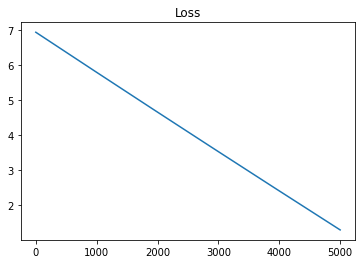

In [67]:
plt.title("Loss")
plt.plot(losses)
plt.show()